## Run initialization in analysis.py

In [1]:
# -*- coding: utf-8 -*-
"""
"""
import matplotlib
matplotlib.use('Agg')

from analysis_and_visualization import perform_analysis_and_visualization
from mozaik.storage.datastore import Hdf5DataStore, PickledDataStore
from mozaik.controller import Global
from parameters import ParameterSet
import mozaik
from mozaik.controller import setup_logging
import sys 

root = '20210328-182636[param.defaults]CombinationParamSearch{trial:[1]}/SelfSustainedPushPull_ParameterSearch_____trial:1'
Global.root_directory = root+'/'

setup_logging()
data_store = PickledDataStore(load=True, parameters=ParameterSet(
    {'root_directory': root, 'store_stimuli': False}), replace=True)

## Imports for analysis and visualization

In [2]:
import os
import psutil
import sys
import mozaik
from mozaik.visualization.plotting import *
from mozaik.analysis.technical import NeuronAnnotationsToPerNeuronValues
from mozaik.analysis.analysis import *
from mozaik.analysis.vision import *
from mozaik.storage.queries import *
from mozaik.storage.datastore import PickledDataStore
from mozaik.controller import Global
from visualization_functions import *

In [3]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy import signal
from scipy import stats

## Import stimulus response class and RF func

In [4]:
class ExportStimulusResponseData(Analysis):
      """
      This analysis exports paired stimulus vs response data. Its intended use is to generate input to
      ML models for identification of stimulus-response function. 

      If signal_type= Vm or cond_Eor cond_I, corresponding recorded signal will be exported.
      If signal_type=ASL, the analysis assumes a datastore filled with AnalogSignalList data structures of identical parametrization with the exception of stimulus.

      Stimulus-response pairs will be concatenated across all different segments or AnalogSignalList data structures in the data store view. 

      For each semgent or AnalogSignalList of signal length X ms, X/period data pairs (A,B) will be exported, where
      A is 2D matrix corresponding to the pixels of the stimulus presented during the given period in the visual field 
      (the stimulus is assumed to be constant during the period). B is the response signal averaged over the given period.

      Following structure will be dumped using the cpickle.dump method into the export file:
      {
        "stim" : ndarray,  #contains 3D ndarray of size (X,Y,T), where X,Y are the visual field dimensions, and T corresponds to the number of periods across all the segments or AnalogSignalLists in the provided data store view. 
        "resp" : ndarray,  #contains 2D ndarray of size (T,N), where T was explained above and N us the number of neurons.      
      }



      Other parameters
      ------------------- 
      period : float (ms)
                     The period over which to average the response signal. The stimulus has to be constant over this period of time.

      neurons : list(int)
                     List of neuron ids for which to export the response

      signal_type : str
                     Currently understood are [Vm,cond_E,cond_I, ASL]. The first three are the corresponding recorded signals. ASL is any AnalogSignalList deposited in the analysis data store. 

      file_name : str
                     The name of the file into which data will be stored. The file will be created in the directory containing the datastore. 
      """    
      required_parameters = ParameterSet({
          'period': float,  
          'neurons' : list,
          'signal_type' : str,
          'file_name' : str
      })      

      def perform_analysis(self):
            if self.parameters.signal_type == 'ASL':
                assert queries.equal_ads(self.datastore,except_params=['stimulus_id'])
                assert queries.ads_with_equal_stimulus_type(self.datastore)
                # make sure that the length of all stimuli is multiple of frame length
                assert all([(MozaikParametrized.idd(s).duration % MozaikParametrized.idd(asl.stimulus_id).frame_duration) == 0 for asl in self.datastore.get_analysis_result()])
                frame_duration = MozaikParametrized.idd(self.datastore.get_analysis_result()[0].stimulus_id).frame_duration
            else:
                assert queries.equal_stimulus_type(self.datastore)
                # make sure that the length of all stimuli is multiple of frame length
                assert all([(MozaikParametrized.idd(s).duration % MozaikParametrized.idd(s).frame_duration) == 0 for s in self.datastore.get_stimuli()])
                frame_duration = MozaikParametrized.idd(self.datastore.get_stimuli()[0]).frame_duration
            print("stop: 0")
            if self.parameters.signal_type == 'ASL':
                signals,stims = zip(*[(asl.get_asl_by_id(self.parameters.neurons),self.datastore.get_sensory_stimulus([asl.stimulus_id])[0]) for asl in queries.param_filter_query(self.datastore,identifier='AnalogSignalList').get_analysis_result()])
            elif self.parameters.signal_type == 'Vm':
                signals,stims = zip(*[([seg.get_vm(n) for n in self.parameters.neurons],self.datastore.get_sensory_stimulus([st])[0]) for seg,st in zip(self.datastore.get_segments(),self.datastore.get_stimuli())])
            elif self.parameters.signal_type == 'cond_E':
                signals,stims = zip(*[([seg.get_esyn(n) for n in self.parameters.neurons],self.datastore.get_sensory_stimulus([st])[0]) for seg,st in zip(self.datastore.get_segments(),self.datastore.get_stimuli())])                
            elif self.parameters.signal_type == 'cond_I':
                signals,stims = zip(*[([seg.get_isyn(n) for n in self.parameters.neurons],self.datastore.get_sensory_stimulus([st])[0]) for seg,st in zip(self.datastore.get_segments(),self.datastore.get_stimuli())])

            signals = numpy.array([[numpy.reshape(s.magnitude[1:],(int((s.duration.rescale(qt.ms).magnitude-1)/self.parameters.period),-1)) for s in sig] for sig in signals])            
            # push neurons into first axes           
            signals = numpy.swapaxes(signals,0,1)  
            # concatenate over the different recordings or ASLs if there are multiple
            signals = [numpy.concatenate(s,axis=0)  for s in signals]  
            # push neurons last           
            signals = numpy.swapaxes(signals,0,1)
            signals = numpy.swapaxes(signals,1,2)  
            raw_signals = signals.copy()
            logger.info(numpy.shape(raw_signals))

            # average over the signal period
            signals = numpy.mean(signals[:,35:,:],axis=1)
            logger.info(numpy.shape(signals))

            # concatenate over the different recordings or ASLs
            stims = numpy.concatenate(stims)  
            logger.info(numpy.shape(stims))

            #cut up for the indiviudal stimulus presentations of length period
            sh = numpy.shape(stims)
            stims = numpy.reshape(stims,(-1,int(self.parameters.period/frame_duration),sh[1],sh[2]))
            logger.info(numpy.shape(stims))

            # check if the inputs are the same within each period 
            #for i in xrange(0,int(self.parameters.period/frame_duration)):
            #    assert numpy.all(stims[:,0,:,:]==stims[:,i,:,:])
            # remove the same stimuli by averaging over them
            stims = numpy.mean(stims[:,:2,:],axis=1)
            logger.info(numpy.shape(stims))
            return signals,raw_signals,stims

## Calc stimulus response

In [5]:
sheets = ["V1_Exc_L4",'V1_Exc_L2/3']
signals = {}
raw_signals = {}
stims = {}
neuron_ids = {}
for sheet in sheets:
    analog_ids = ( 
        param_filter_query(data_store, sheet_name=sheet)
        .get_segments()[0]
        .get_stored_esyn_ids()
    )
    spike_ids = ( 
        param_filter_query(data_store, sheet_name=sheet)
        .get_segments()[0]
        .get_stored_spike_train_ids()
    )
    ids = list(set(spike_ids) & set(analog_ids))

    srd_params = { 
          'period': 70,  
          'neurons' : ids,
          'signal_type' : "Vm",
          'file_name' : ""
    }
    dsv = param_filter_query(data_store,st_name='SparseNoise',sheet_name=sheet,st_direct_stimulation_name=None)
    signals_0,raw_signals_0,stims_0 = ExportStimulusResponseData(dsv,ParameterSet(srd_params)).perform_analysis()
    signals[sheet] = signals_0
    raw_signals[sheet] = raw_signals_0
    stims[sheet] = stims_0
    neuron_ids[sheet] = ids

  (2880, 70, 100)
  (2880, 100)


stop: 0


  (28800, 45, 45)
  (2880, 10, 45, 45)
  (2880, 45, 45)
  (2880, 70, 75)
  (2880, 75)


stop: 0


  (28800, 45, 45)
  (2880, 10, 45, 45)
  (2880, 45, 45)


## Calculate RFs

In [6]:
def get_RFs(stims,signals):
    rescaled_stims = (stims-50.0)/50.0
    pos = rescaled_stims[0]*0
    neg = rescaled_stims[0]*0
    for i in xrange(stims.shape[0]):
        pos += numpy.clip(rescaled_stims[i],a_min=0,a_max=None)
        neg += numpy.clip(rescaled_stims[i],a_max=0,a_min=None)
    
    RFs=[]
    for j in xrange(signals.shape[1]):
        apos = rescaled_stims[0]*0
        aneg = rescaled_stims[0]*0
        for i in xrange(signals.shape[0]):
            apos += numpy.clip(rescaled_stims[i],a_min=0,a_max=None)*signals[i,j]
            aneg += numpy.clip(rescaled_stims[i],a_min=None,a_max=0)*signals[i,j]

        b = numpy.divide(apos,pos) - numpy.divide(aneg,neg)
        RFs.append(b)

    RFs=numpy.nan_to_num(RFs)
    return RFs

def get_RFs_corr_Benoit(stims,signals):
    """
    17. Reverse correlation analysis: A d.c. offset was applied to the high-pass filtered voltage records 
    (1 Hz, elliptic filter) such as to center the mode of the membrane potential distribution on a null value. 
    Successive local extrema were defined as being separated by at least 0.5-mV amplitude. 
    Depolarizing events were selected as local positive maxima. Hyperpolarizing events
    were defined as local minima whose amplitude remained below 21 mV.
    To assess the statistical significance of the maps, we carried out similar procedures of correlation counts 
    (established over a 25-ms window) in the reverse and forward directions. The reverse-correlation delay 
    [varied from 2200 to 0 (retrograde) and 0 to 200 ms (forward) with a 1-ms step] was optimized independently 
    for each visual field pixel such as to maximize the z score given by [number of counts (reverse) 2 mean 
    (forward)]/SD (forward). The forward procedure allowed us to  empirically establish the distribution of the 
    maximal count obtained in a given pixel, under the null hypothesis of independent output and input processes,
    and define a one-tailed rejection threshold (statistical significance of 1% ). The maps presented here are 
    thus without any temporal significance and focus on the spatial structure of the receptive field. Measures
    of the spatial extent of maps independent of their patchiness were expressed by the diameter of the disk
    covering the same total area, expressed in degrees of visual angle.
    """
    # Center voltage signal around 0
    
    # Nonmaxsuppression - extrema have to be separated by at least 0.5 mV
    
    # Select depolarizing events as local positive maxima
    
    # Select hyperpolarizing events as local minima below amplitude of 21mV
    
    # Something something receptive field
    
l4_RFs = get_RFs(stims["V1_Exc_L4"],signals["V1_Exc_L4"])
#l23_RFs = get_RFs(stims["V1_Exc_L2/3"],signals["V1_Exc_L2/3"])
#l4_RFs = get_RFs_corr(stims["V1_Exc_L4"],raw_signals["V1_Exc_L4"])

In [7]:
%matplotlib inline
import time
def second_rf_better(rf_0, rf_1):
    # True if the second RF is better than the first

    # Condition: maximum of absolute value
    #return np.abs(rf_0).max() < np.abs(rf_1).max()

    # Squared sum
    return np.sum(rf_0**2) < np.sum(rf_1**2)

def crop_and_resize_stim(stim, visual_field_size, visual_field_spatial_resolution, stim_size, grid_size):
    ymin = int(np.ceil((visual_field_size[0]-stim_size)/(2*visual_field_spatial_resolution)))
    ymax = ymin + int(stim_size/visual_field_spatial_resolution)
    xmin = int(np.ceil((visual_field_size[1]-stim_size)/(2*visual_field_spatial_resolution)))
    xmax = xmin + int(stim_size/visual_field_spatial_resolution)

    step = int(np.round(stim_size/(grid_size*visual_field_spatial_resolution)))
    cropped_stim = stim[:,ymin:ymax,xmin:xmax]
    cropped_stim = cropped_stim[:,::step,::step]
    return cropped_stim

def Jones_Palmer_rfs(stims,raw_signals,background_luminance,max_delay):
    rescaled_stims = (stims-background_luminance)/background_luminance
    pos = rescaled_stims[0]*0
    neg = rescaled_stims[0]*0
    for i in xrange(rescaled_stims.shape[0]):
        pos += numpy.clip(rescaled_stims[i],a_min=0,a_max=None)
        neg += numpy.clip(rescaled_stims[i],a_max=0,a_min=None)
    
    n_stims, period, n_neurons= raw_signals.shape
    _, stim_d0, stim_d1 = rescaled_stims.shape
    print("Number of stimuli: %d, period: %d ms, number of neurons: %d" % (n_stims,period,n_neurons))
    
    start = time.time()
    RFs = []
    distrs=[]
    latencies=[]
    for n_id in range(n_neurons):
        # Select signal for given neuron
        signal = raw_signals[:,:,n_id]
        signal = signal.flatten()
        signal_averaged = np.convolve(signal,np.ones(period)/period,'valid')
        
        t1 = time.time()
        all_RF_pos = np.zeros((period,rescaled_stims[0].shape[0],rescaled_stims[0].shape[1]))
        all_RF_neg = np.zeros((period,rescaled_stims[0].shape[0],rescaled_stims[0].shape[1]))
        A,B,C = np.where(rescaled_stims[0:-1,:,:] > 0)
        for i in range(len(A)):
            all_RF_pos[:,B[i],C[i]] += signal_averaged[A[i]*period:A[i]*period+period]
        A,B,C = np.where(rescaled_stims[0:-1,:,:] < 0)
        for i in range(len(A)):
            all_RF_neg[:,B[i],C[i]] += signal_averaged[A[i]*period:A[i]*period+period]
        all_RF = (all_RF_pos / pos) - (all_RF_neg / -neg) 
        all_RF = np.nan_to_num(all_RF)
        t2 = time.time()
        best_RF = np.zeros(rescaled_stims[0].shape)
        for d0 in xrange(stim_d0):
            for d1 in xrange(stim_d1):
                best_RF[d0,d1] = max(all_RF[:,d0,d1],key=abs)
        latency = np.argmax(abs(all_RF),axis=0)
        print("RF calculation done")

        n_samples = 1000
        distr = np.zeros((n_samples,stim_d0,stim_d1))
        #s = signal_averaged[42:-1:period]
        for d0 in xrange(stim_d0): # stim_d0
            for d1 in xrange(stim_d1): #stim_d1
                p = int(pos[d0,d1])
                n = int(-neg[d0,d1])
                s = signal_averaged[latency[d0,d1]:-1:period]
                for i in range(n_samples):
                    rnd_s = np.random.choice(s, size=p+n, replace=False)
                    apos = rnd_s[:p].mean()
                    aneg = rnd_s[p:].mean()
                    distr[i,d0,d1] = apos-aneg

        distrs.append(distr)
        end = time.time()
        print("Neuron %d finished at %.2f s" % (n_id, end-start))        
        RFs.append(best_RF)
    return RFs, distrs

rel_n_id = [6,13,64,91,93] # relevant neuron ids
#rel_n_id = range(100)
rf_stims = crop_and_resize_stim(stims["V1_Exc_L4"], (4.5,4.5), 0.1, 3.6, 12)
#RFs, distrs = Jones_Palmer_rfs(rf_stims,raw_signals["V1_Exc_L4"][:,:,rel_n_id],50.0,80)
RFs, distrs = Jones_Palmer_rfs(rf_stims,raw_signals["V1_Exc_L4"],50.0,80)

Number of stimuli: 2880, period: 70 ms, number of neurons: 100
RF calculation done
Neuron 0 finished at 9.81 s
RF calculation done
Neuron 1 finished at 19.59 s
RF calculation done
Neuron 2 finished at 29.36 s
RF calculation done
Neuron 3 finished at 39.12 s
RF calculation done
Neuron 4 finished at 48.89 s
RF calculation done
Neuron 5 finished at 58.65 s
RF calculation done
Neuron 6 finished at 68.45 s
RF calculation done
Neuron 7 finished at 78.22 s
RF calculation done
Neuron 8 finished at 87.99 s
RF calculation done
Neuron 9 finished at 97.73 s
RF calculation done
Neuron 10 finished at 107.50 s
RF calculation done
Neuron 11 finished at 117.28 s
RF calculation done
Neuron 12 finished at 127.04 s
RF calculation done
Neuron 13 finished at 136.78 s
RF calculation done
Neuron 14 finished at 146.61 s
RF calculation done
Neuron 15 finished at 156.37 s
RF calculation done
Neuron 16 finished at 166.15 s
RF calculation done
Neuron 17 finished at 175.92 s
RF calculation done
Neuron 18 finished a

In [8]:
def confidence_mask(RF,distr,p):
    RF_d0, RF_d1 = RF.shape
    lthresh = np.zeros((RF_d0, RF_d1))
    hthresh = np.zeros((RF_d0, RF_d1))
    for d0 in range(RF_d0):
        for d1 in range(RF_d1):
            hthresh[d0,d1], lthresh[d0,d1] = np.percentile(distr[:,d0,d1],[(1-p/2)*100,p/2*100])
    mask = np.logical_or(RF < lthresh, RF > hthresh)
    return mask

p=0.01
RFs_masked = []
masks = []
for i in range(len(RFs)):
    mask = confidence_mask(RFs[i],distrs[i],p)
    masks.append(mask)
    RFs_masked.append(mask*RFs[i])
    #print(RFs_masked[i].shape)

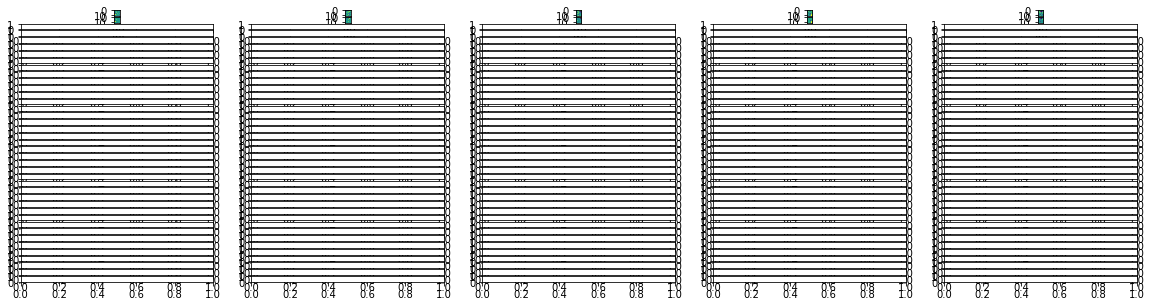

In [9]:
%matplotlib inline
visual_field_spatial_resolution = 0.1 # degrees
h, w = len(RFs*2)/5,5
figure, axis = plt.subplots(h, w)
figure.set_figheight(5)
figure.set_figwidth(20)
#for i in range(h):
for j in range(w):
        #axis[i, j].set_title('id: %d, x: %.2f, y: %.2f' % (i*w+j,l4_params[l4_ids[i*w+j]]["x"], l4_params[l4_ids[i*w+j]]["y"]))
    #axis[i, j].imshow(RFs[i*w+j])
    axis[0, j].imshow(RFs[j])
    axis[1, j].imshow(RFs_masked[j])
plt.show()

NameError: name 'l4_params' is not defined

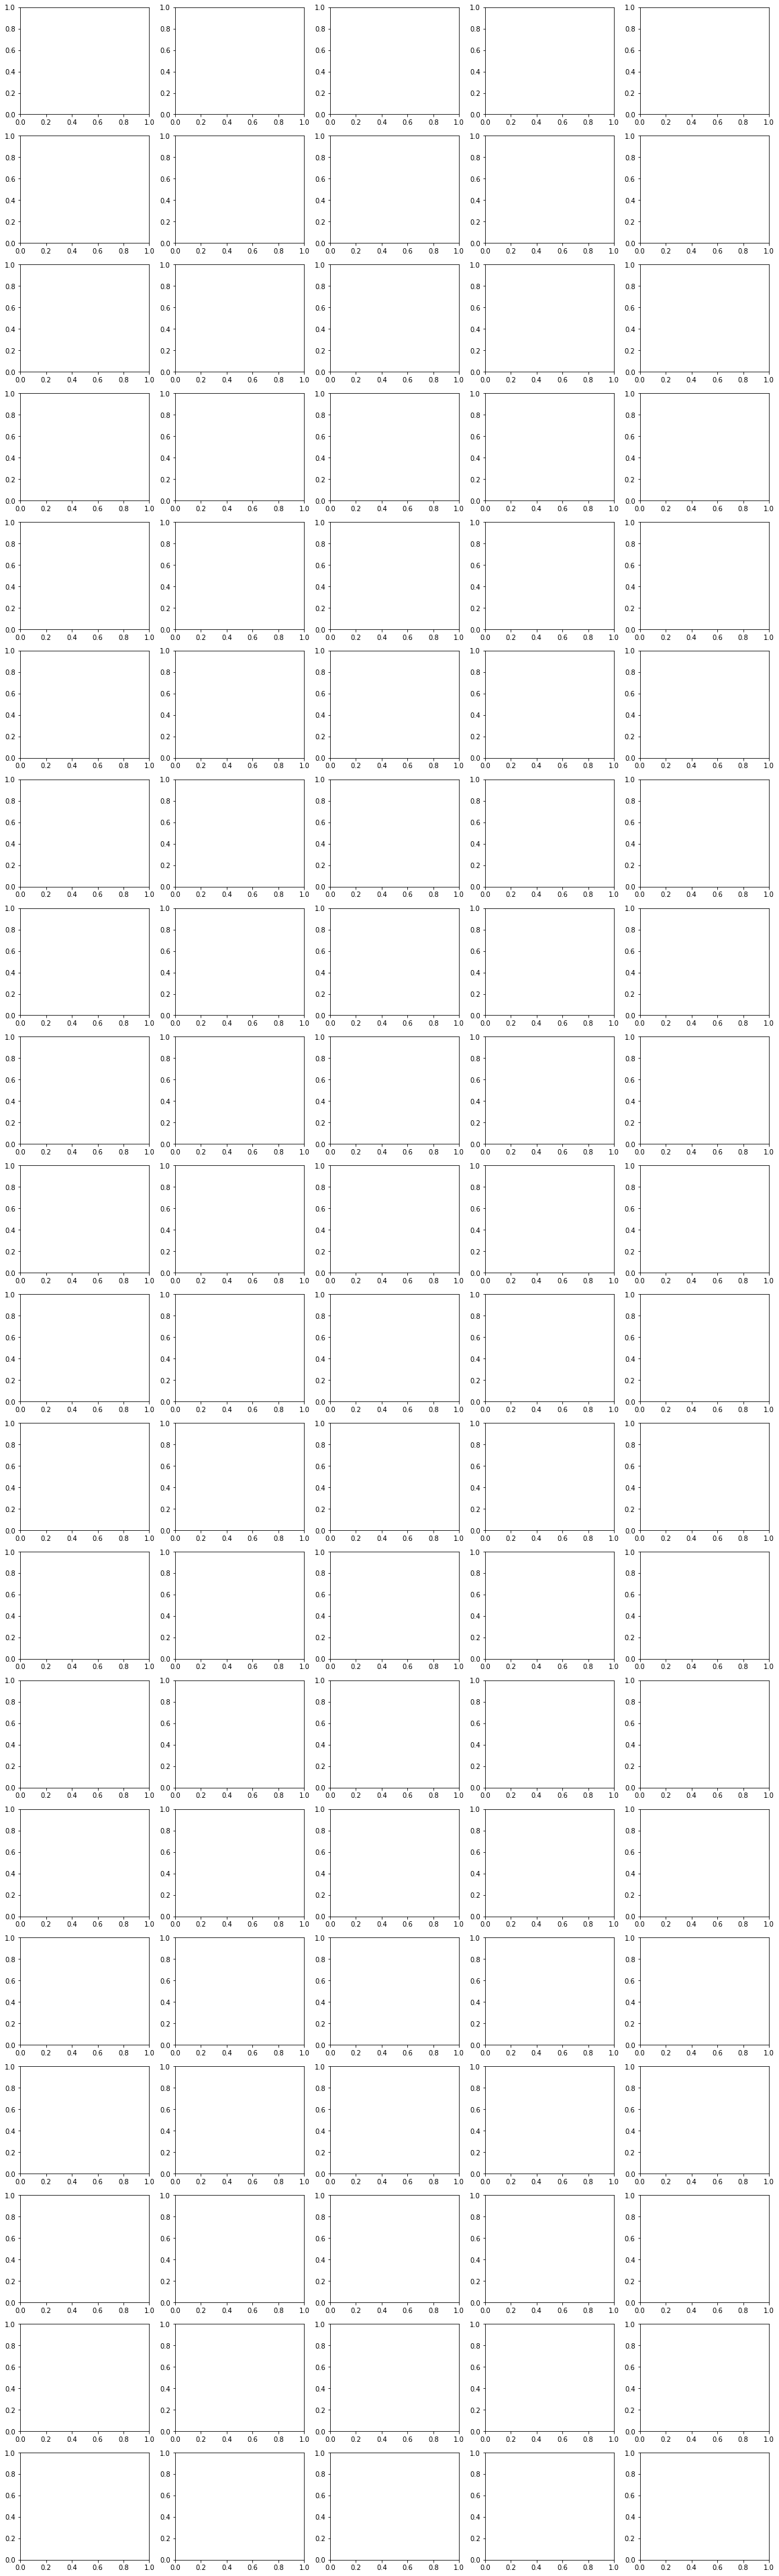

In [10]:
%matplotlib inline
h, w = len(RFs)/5,5
figure, axis = plt.subplots(h, w)
figure.set_figheight(70)
figure.set_figwidth(20)
for i in range(h):
    for j in range(w):
        n_id = neuron_ids["V1_Exc_L4"][i*w+j]
        axis[i, j].set_title('id: %d, x: %.2f, y: %.2f' % (i*w+j,l4_params[n_id]["x"], l4_params[n_id]["y"]))
        #axis[i, j].imshow(RFs[i*w+j])
        axis[i, j].imshow(RFs_masked[i*w+j])
plt.show()

## Get generated RF params

In [11]:
from tools import rf_params_from_annotations
l4_params = rf_params_from_annotations(data_store,"V1_Exc_L4")
l23_params = rf_params_from_annotations(data_store,"V1_Exc_L2/3")

  Starting NeuronAnnotationsToPerNeuronValues analysis
  Starting NeuronAnnotationsToPerNeuronValues Analysis
NeuronAnnotationsToPerNeuronValues analysis took: 0.258565187454seconds
  Starting NeuronAnnotationsToPerNeuronValues analysis
  Starting NeuronAnnotationsToPerNeuronValues Analysis
NeuronAnnotationsToPerNeuronValues analysis took: 0.279229879379seconds


## Calc RF sizes

In [36]:
%matplotlib inline
from scipy import optimize
from scipy.ndimage import center_of_mass

def get_diameter(RF, x_center, y_center):
    y,x = np.where(np.abs(RF)>0)
    diameter = np.sqrt((x-x_center)**2 + (y-y_center)**2)
    return max(diameter)

def gaussian(height, center_y, center_x, sigma):
    """Returns a gaussian function with the given parameters"""
    sigma = float(sigma)
    return lambda y,x: height*np.exp(
                -(((center_x-x)/sigma)**2+((center_y-y)/sigma)**2)/2)

def fitgaussian(data):
    """Returns (height, y, x, sigma)
    the gaussian parameters of a 2D distribution found by a fit"""
    y0,x0 = center_of_mass(data)
    params = [1,y0,x0,1]
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

def get_size_and_coords(RF):   
    mode = "GAUSS_FIT"
    
    if mode is "MAX":
        # Get absolute maximum index
        id_1d = np.abs(RF).argmax()
        y,x = np.unravel_index(id_1d, RFs[0].shape)
        #print(y,x)
        diameter = get_diameter(RF, x, y)       

    elif mode is "GAUSS_FIT":
        height,y,x,sigma = fitgaussian(np.abs(RF))
        #print(height,x,y,sigma)
        diameter = 4*sigma
    return diameter,x,y

def transform_to_real_coords(RF,diameter,x,y):
    stim_size = 3.6
    grid_size = 12
    xlen, ylen = RFs[0].shape    
    x_real = (x-xlen/2 - np.sign(x-xlen/2) * 0.5) * (stim_size/grid_size)
    y_real = -(y-ylen/2 - np.sign(y-ylen/2) * 0.5) * (stim_size/grid_size)
    diameter_real = diameter * (stim_size/grid_size)
    return diameter_real, x_real, y_real
        
calculated_neuron_params = {}
plot_neuron_params = {}
for i in range(len(RFs)):
    diameter, x, y = get_size_and_coords(RFs_masked[i])
    diameter_real, x_real, y_real = transform_to_real_coords(RFs_masked[i],diameter,x,y)
    calculated_neuron_params[neuron_ids["V1_Exc_L4"][i]] = {"x" : x_real, "y" : y_real, "diameter" : diameter_real,
                                                            "RF" : RFs[i], "RF_masked" : RFs_masked[i]}
    plot_neuron_params[neuron_ids["V1_Exc_L4"][i]] = {"x" : x, "y" : y, "diameter" : diameter}
    

## Plot layer 4 RFs

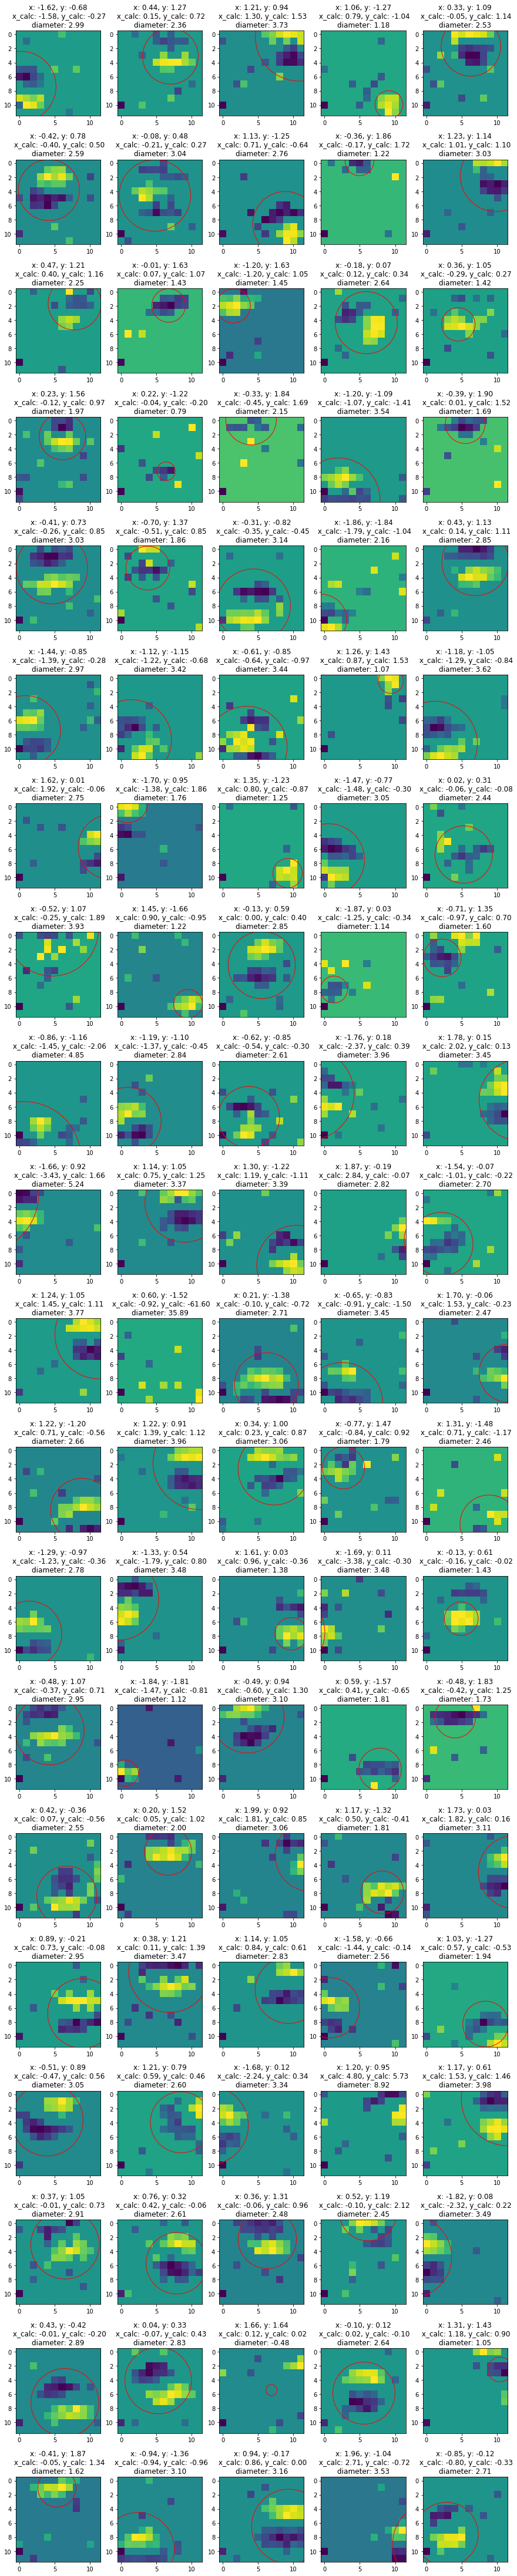

In [33]:
%matplotlib inline
#RFs = l4_RFs
h, w = len(RFs_masked)/5, 5
figure, axis = plt.subplots(h, w)
figure.set_figheight(80)
figure.set_figwidth(15)
for i in range(h):
    for j in range(w):
        n_id = neuron_ids["V1_Exc_L4"][i*w+j]
        axis[i,j].set_title('x: %.2f, y: %.2f\n x_calc: %.2f, y_calc: %.2f\ndiameter: %.2f' % 
                         (l4_params[n_id]["x"],l4_params[n_id]["y"],
                          calculated_neuron_params[n_id]["x"], calculated_neuron_params[n_id]["y"],
                          calculated_neuron_params[n_id]["diameter"]))
        #axis[j].imshow(np.abs(RFs_masked[i*w+j]))
        axis[i,j].imshow(RFs_masked[i*w+j])
        circ = plt.Circle((plot_neuron_params[n_id]["x"], plot_neuron_params[n_id]["y"]),
                           plot_neuron_params[n_id]["diameter"]/2.0,fill=False,color='r')
        axis[i,j].add_artist(circ)
        
plt.show()

## Filter out non-central or too small/large RF neurons

In [39]:
def remove_extreme_neurons(neuron_params,xlim,ylim,dlim):
    out = {}
    for n_id, params in neuron_params.items():
        if \
        params["x"] >= xlim[0] and params["x"] <= xlim[1] and \
        params["y"] >= ylim[0] and params["y"] <= ylim[1] and \
        params["diameter"] >= dlim[0] and params["diameter"] <= dlim[1]:
            out[n_id] = params.copy()
    return out
            
nparams_2 = remove_extreme_neurons(calculated_neuron_params,[-1,1],[-1,1],[2.0,4.5])

## Save results to datastore
Values:
- Receptive Field
- Masked Receptive Field
- Receptive Field x
- Receptive Field y
- Receptive Field sigma

In [44]:
def save_in_datastore(datastore, neuron_params, sheet):
    ids = []
    RFs = []
    RFs_masked = []
    x = []
    y = []
    sigma = []
    for n_id in neuron_params: 
        ids.append(n_id)
        RFs.append(neuron_params[n_id]["RF"])
        RFs_masked.append(neuron_params[n_id]["RF_masked"])
        x.append(neuron_params[n_id]["x"])
        y.append(neuron_params[n_id]["y"])
        sigma.append(neuron_params[n_id]["diameter"] / 6) # diameter is 3 SD-s
        
    datastore.full_datastore.add_analysis_result(
        PerNeuronValue(RFs, ids, None,
                        value_name='Receptive Field',
                        sheet_name=sheet,
                        period=None))
    datastore.full_datastore.add_analysis_result(
        PerNeuronValue(RFs_masked, ids, None,
                        value_name='Masked Receptive Field',
                        sheet_name=sheet,
                        period=None))
    datastore.full_datastore.add_analysis_result(
        PerNeuronValue(x, ids, None,
                        value_name='Receptive Field x',
                        sheet_name=sheet,
                        period=None)) 
    datastore.full_datastore.add_analysis_result(
        PerNeuronValue(y, ids, None,
                        value_name='Receptive Field y',
                        sheet_name=sheet,
                        period=None)) 
    datastore.full_datastore.add_analysis_result(
        PerNeuronValue(sigma, ids, None,
                        value_name='Receptive Field sigma',
                        sheet_name=sheet,
                        period=None)) 
    
save_in_datastore(data_store,nparams_2,"V1_Exc_L4")